In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.stem import WordNetLemmatizer
import tqdm
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Concatenate, Dense, Input,Dropout
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, AdamW

In [2]:
# Specify the folder path where your CSV files are located
folder_path = "/Users/kianathakkar/Documents/dataset/quora-question-pairs/train.csv"

df_train = pd.read_csv(folder_path)

In [3]:
# Specify the folder path where your CSV files are located
folder_path_test = "/Users/kianathakkar/Documents/dataset/quora-question-pairs/test.csv"

df_test = pd.read_csv(folder_path_test)

In [4]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df_train = df_train.dropna()

In [6]:
# Tokenization and Lemmatization
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kianathakkar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Preprocessing and Cleaning Text Data
def preprocess_text(text):
    
    # Check if the input is a non-empty string
    if isinstance(text, str) and text.strip():  # Check if it's a non-empty string
        # Lowercase the text
        text = text.lower()

        # Replace certain special characters with their string equivalents
        text = text.replace('%', ' percent')
        text = text.replace('$', ' dollar ')
        text = text.replace('₹', ' rupee ')
        text = text.replace('€', ' euro ')
        text = text.replace('@', ' at ')
        
        # The pattern '[math]' appears around 900 times in the whole dataset.
        text = text.replace('[math]', '')       

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
         
    return text

In [8]:
# Define a dictionary of common English contractions and their expanded forms
contractions_dict = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "might've": "might have",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we would",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "when's": "when is",
    "where's": "where is",
    "who's": "who is",
    "why's": "why is",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

# Function to expand contractions
def expand_contractions(text, contractions_dict):
    
    if isinstance(text, str):
        words = text.split()
        expanded_words = [contractions_dict.get(word, word) for word in words]
        expanded_text = " ".join(expanded_words)
        return expanded_text
    else:
        return text 
    

In [9]:
# Tokenization and Lemmatization
def tokenize_and_lemmatize(text):
    if isinstance(text, str):
        words = text.split()
        words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)
    else:
        return text  # Return the input as is if it's not a string

In [10]:

# List of column names to clean
columns_to_clean = ['question1','question2']

# Apply the functions to each column in the DataFrame
for column in columns_to_clean:
    # Apply the special character removal function
    df_train[column] = df_train[column].apply(preprocess_text)
    df_test[column] = df_test[column].apply(preprocess_text)

    # Apply the contraction expansion function
    df_train[column] = df_train[column].apply(expand_contractions, args=(contractions_dict,))
    df_test[column] = df_test[column].apply(expand_contractions, args=(contractions_dict,))   
     
    # Apply the stop word removal function
    df_train[column] = df_train[column].apply(tokenize_and_lemmatize)
    df_test[column] = df_test[column].apply(tokenize_and_lemmatize)

In [11]:
df_train['question1'] = df_train['question1'].astype(str)
df_train['question2'] = df_train['question2'].astype(str)

In [12]:
# Assuming you have preprocessed text in 'question1' and 'question2' columns
question1_texts = df_train['question1'].apply(lambda x: str(x))
question2_texts = df_train['question2'].apply(lambda x: str(x))

# Tokenize the text in both columns
question1_tokens = [word_tokenize(text) for text in question1_texts]
question2_tokens = [word_tokenize(text) for text in question2_texts]

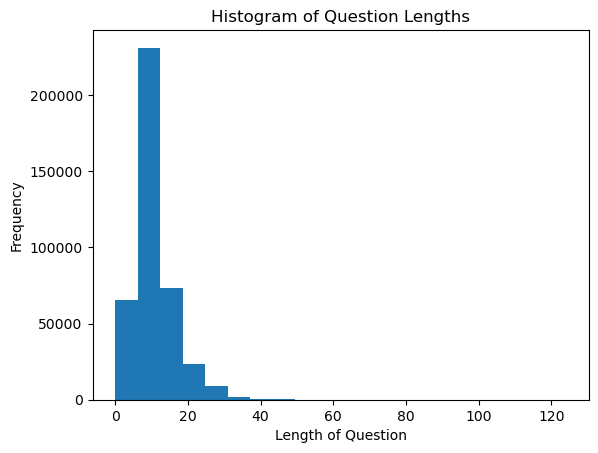

In [13]:
import matplotlib.pyplot as plt

# Create a list to store the lengths of the internal lists
lengths = [len(internal_list) for internal_list in question1_tokens]

# Create a histogram
plt.hist(lengths, bins=20)  # Adjust the number of bins as needed
plt.xlabel('Length of Question')
plt.ylabel('Frequency')
plt.title('Histogram of Question Lengths')

# Show the histogram
plt.show()

In [14]:
# Tokenization and sequence padding
max_seq_length = 40  # Define your maximum sequence length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(question1_tokens + question2_tokens)

question1_sequences = tokenizer.texts_to_sequences(question1_tokens)
question2_sequences = tokenizer.texts_to_sequences(question2_tokens)
question1_sequences = pad_sequences(question1_sequences, maxlen=max_seq_length)
question2_sequences = pad_sequences(question2_sequences, maxlen=max_seq_length)


In [15]:
# Split data into training and testing sets
X = np.column_stack((question1_sequences, question2_sequences))
y = df_train['is_duplicate'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Build the LSTM model
embedding_dim = 100  
lstm_units = 64

input1 = Input(shape=(max_seq_length,))
input2 = Input(shape=(max_seq_length,))

embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim)
lstm_layer = LSTM(lstm_units)

encoded1 = lstm_layer(embedding_layer(input1))
encoded2 = lstm_layer(embedding_layer(input2))

2023-10-07 22:59:06.176249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-07 22:59:06.177258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-07 22:59:06.177739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [17]:
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape)

(90210, 100)


In [18]:
# Concatenate 
merged = Concatenate()([encoded1, encoded2])

# Add one or more Dense layers
dense_units = 128  # Define the number of units in the dense layers

dense1 = Dense(dense_units, activation='relu', kernel_initializer=HeNormal())(merged)  # Add a dense layer after the Concatenate layer
dense2 = Dense(dense_units, activation='relu', kernel_initializer=HeNormal())(dense1)  # Optionally, you can add more dense layers

# Add the final output layer
output = Dense(1, activation='sigmoid')(dense2)

model_lstm = Model(inputs=[input1, input2], outputs=output)

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [19]:
model_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 100)      9021000     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 64)           42240       ['embedding[0][0]',          

In [20]:
from keras.utils.vis_utils import plot_model

plot_model(model_lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
# Train the model
model_lstm.fit([X_train[:, :max_seq_length], X_train[:, max_seq_length:]], y_train, batch_size=64, epochs=5, validation_data=([X_test[:, :max_seq_length], X_test[:, max_seq_length:]], y_test))

Epoch 1/5


2023-10-07 22:59:06.481841: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-07 22:59:06.644571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-07 22:59:06.645211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-07 22:59:06.645763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

5053/5054 [============================>.] - ETA: 0s - loss: 0.4668 - accuracy: 0.7751

2023-10-07 23:04:30.590366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-07 23:04:30.591623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-07 23:04:30.592316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5054/5054 [==============================] - 332s 65ms/step - loss: 0.4668 - accuracy: 0.7751 - val_loss: 0.4249 - val_accuracy: 0.8026
Epoch 2/5
5054/5054 [==============================] - 241s 48ms/step - loss: 0.3450 - accuracy: 0.8451 - val_loss: 0.3916 - val_accuracy: 0.8218
Epoch 3/5
5054/5054 [==============================] - 264s 52ms/step - loss: 0.2676 - accuracy: 0.8845 - val_loss: 0.4017 - val_accuracy: 0.8278
Epoch 4/5
5054/5054 [==============================] - 273s 54ms/step - loss: 0.2097 - accuracy: 0.9115 - val_loss: 0.4489 - val_accuracy: 0.8288
Epoch 5/5
5054/5054 [==============================] - 273s 54ms/step - loss: 0.1650 - accuracy: 0.9316 - val_loss: 0.5009 - val_accuracy: 0.8273


### Getting the best threshold for the model

In [22]:
from sklearn.metrics import precision_recall_curve,auc,f1_score

# Assuming you have a trained model 'model'
y_prob = model_lstm.predict([X_test[:, :max_seq_length], X_test[:, max_seq_length:]])

2023-10-07 23:22:08.653221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-07 23:22:08.654023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-07 23:22:08.654590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2527/2527 [==============================] - 12s 4ms/step


In [23]:
best_threshold = 0
best_f1 = 0

for threshold in range(1, 100):
    threshold /= 100
    y_pred_binary = (y_prob > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_binary)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1:.2f}")

Best Threshold: 0.38
Best F1 Score: 0.78


### Precision Recall Curve

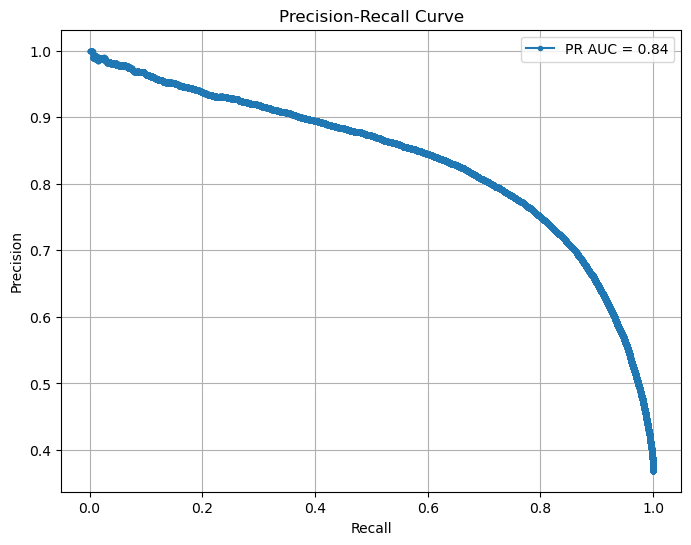

In [24]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
area_under_curve = auc(recalls, precisions)  # Calculate the AUC

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.', label=f'PR AUC = {area_under_curve:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

### Using the classifier with optimum threshold to get classification report

In [25]:
from sklearn.metrics import classification_report

# Assuming you have a trained model 'model'
y_pred = model_lstm.predict([X_test[:, :max_seq_length], X_test[:, max_seq_length:]])

# Convert the predictions to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.48).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred_binary))

2527/2527 [==============================] - 10s 4ms/step
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     51026
           1       0.74      0.81      0.77     29832

    accuracy                           0.83     80858
   macro avg       0.81      0.82      0.82     80858
weighted avg       0.83      0.83      0.83     80858



### Using Transformer Architecture for classification

In [26]:
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer,BertForSequenceClassification
from transformers import DistilBertTokenizerFast,DistilBertForSequenceClassification
import torch

In [27]:
# Create a DistilBERT tokenizer
tokenizer_dbert = BertTokenizer.from_pretrained('bert-base-uncased')

# Create a DistilBERT model
model_dbert = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
random_indices = random.sample(range(len(df_train)), 5000)
df_sampled = df_train.iloc[random_indices]

#Sample 24,000 data points for training
training_indices = random.sample(range(len(df_sampled)), 4000)
df_train_v2 = df_sampled.iloc[training_indices]

# Create an evaluation DataFrame with the remaining 6,000 data points
evaluation_indices = [i for i in range(len(df_sampled)) if i not in training_indices]
df_eval = df_sampled.iloc[evaluation_indices]

In [29]:
# Prepare sentence pairs and labels for training data
sentence_pairs_train = [(row['question1'], row['question2']) for _, row in df_train_v2.iterrows()]
labels_train = df_train_v2['is_duplicate'].tolist()

In [30]:
#Prepare sentence pairs and labels for validation
sentence_pairs_eval = [(row['question1'], row['question2']) for _, row in df_eval.iterrows()]
labels_eval = df_eval['is_duplicate'].tolist()

In [31]:
encodings_train = tokenizer_dbert(sentence_pairs_train,padding=True, truncation=True)

encodings_eval = tokenizer_dbert(sentence_pairs_eval, padding=True, truncation=True)

In [32]:
type(encodings_train)

transformers.tokenization_utils_base.BatchEncoding

In [33]:
first_record_input_ids = encodings_train['input_ids'][0]
first_record_attention_mask = encodings_train['attention_mask'][0]

In [34]:
class QuestionPairClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

dataset_train = QuestionPairClassificationDataset(encodings_train, labels_train)
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True)

dataset_eval = QuestionPairClassificationDataset(encodings_eval, labels_eval)
dataloader_eval = torch.utils.data.DataLoader(dataset_eval, batch_size=8, shuffle=True)

In [35]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def compute_custom_metrics(eval_prediction):
    predicted_labels = eval_prediction.predictions.argmax(axis=1)
    true_labels = eval_prediction.label_ids

    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)

    return {'precision': precision, 'recall': recall, 'accuracy': accuracy}

In [38]:
training_args = TrainingArguments(
    output_dir="./results",
    report_to="tensorboard",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    save_steps=400,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=200,
)

In [39]:
trainer = Trainer(
    model=model_dbert,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_eval,
    compute_metrics=compute_custom_metrics
)

In [40]:
trainer.train()

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.48701924085617065, 'eval_precision': 0.6686390532544378, 'eval_recall': 0.6141304347826086, 'eval_accuracy': 0.746, 'eval_runtime': 17.1683, 'eval_samples_per_second': 58.247, 'eval_steps_per_second': 7.281, 'epoch': 0.4}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.5090327858924866, 'eval_precision': 0.6675191815856778, 'eval_recall': 0.7092391304347826, 'eval_accuracy': 0.763, 'eval_runtime': 17.4848, 'eval_samples_per_second': 57.192, 'eval_steps_per_second': 7.149, 'epoch': 0.8}
{'loss': 0.5267, 'learning_rate': 4e-05, 'epoch': 1.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.5662055611610413, 'eval_precision': 0.7191358024691358, 'eval_recall': 0.6331521739130435, 'eval_accuracy': 0.774, 'eval_runtime': 17.7632, 'eval_samples_per_second': 56.296, 'eval_steps_per_second': 7.037, 'epoch': 1.2}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.7219766974449158, 'eval_precision': 0.6533957845433255, 'eval_recall': 0.7581521739130435, 'eval_accuracy': 0.763, 'eval_runtime': 19.12, 'eval_samples_per_second': 52.301, 'eval_steps_per_second': 6.538, 'epoch': 1.6}
{'loss': 0.3389, 'learning_rate': 3e-05, 'epoch': 2.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.6010679006576538, 'eval_precision': 0.7110552763819096, 'eval_recall': 0.7690217391304348, 'eval_accuracy': 0.8, 'eval_runtime': 20.1195, 'eval_samples_per_second': 49.703, 'eval_steps_per_second': 6.213, 'epoch': 2.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.801496684551239, 'eval_precision': 0.64, 'eval_recall': 0.8695652173913043, 'eval_accuracy': 0.772, 'eval_runtime': 22.4296, 'eval_samples_per_second': 44.584, 'eval_steps_per_second': 5.573, 'epoch': 2.4}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.0313588380813599, 'eval_precision': 0.6578947368421053, 'eval_recall': 0.8152173913043478, 'eval_accuracy': 0.776, 'eval_runtime': 21.2872, 'eval_samples_per_second': 46.977, 'eval_steps_per_second': 5.872, 'epoch': 2.8}
{'loss': 0.2095, 'learning_rate': 2e-05, 'epoch': 3.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.2353140115737915, 'eval_precision': 0.6621621621621622, 'eval_recall': 0.7989130434782609, 'eval_accuracy': 0.776, 'eval_runtime': 22.0569, 'eval_samples_per_second': 45.337, 'eval_steps_per_second': 5.667, 'epoch': 3.2}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.2184988260269165, 'eval_precision': 0.6822429906542056, 'eval_recall': 0.7934782608695652, 'eval_accuracy': 0.788, 'eval_runtime': 21.1823, 'eval_samples_per_second': 47.209, 'eval_steps_per_second': 5.901, 'epoch': 3.6}
{'loss': 0.0987, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.22787606716156, 'eval_precision': 0.6801909307875895, 'eval_recall': 0.7744565217391305, 'eval_accuracy': 0.783, 'eval_runtime': 20.9354, 'eval_samples_per_second': 47.766, 'eval_steps_per_second': 5.971, 'epoch': 4.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.4315714836120605, 'eval_precision': 0.6681818181818182, 'eval_recall': 0.7989130434782609, 'eval_accuracy': 0.78, 'eval_runtime': 22.4907, 'eval_samples_per_second': 44.463, 'eval_steps_per_second': 5.558, 'epoch': 4.4}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.4211896657943726, 'eval_precision': 0.6888888888888889, 'eval_recall': 0.7581521739130435, 'eval_accuracy': 0.785, 'eval_runtime': 20.3019, 'eval_samples_per_second': 49.256, 'eval_steps_per_second': 6.157, 'epoch': 4.8}
{'loss': 0.0308, 'learning_rate': 0.0, 'epoch': 5.0}
{'train_runtime': 2295.216, 'train_samples_per_second': 8.714, 'train_steps_per_second': 1.089, 'train_loss': 0.24089942626953126, 'epoch': 5.0}


TrainOutput(global_step=2500, training_loss=0.24089942626953126, metrics={'train_runtime': 2295.216, 'train_samples_per_second': 8.714, 'train_steps_per_second': 1.089, 'train_loss': 0.24089942626953126, 'epoch': 5.0})